# Interna

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from wordcloud import WordCloud
from matplotlib_venn import venn2

In [2]:
DATASET = {
  'main': 'datasets/HIV.csv',
  'reference': 'datasets/reference.csv',
  'smiles': 'datasets/smiles.csv',
  'names': 'datasets/smiles.csv'
}

## Load dataset

In [3]:
main_df = pd.read_csv(DATASET['main'], encoding='unicode_escape')
main_df['HIV_active'] = main_df['HIV_active'] == 1

smiles_df = pd.read_csv(DATASET['smiles'])
ref_df = pd.read_csv(DATASET['reference'])
ref_df = ref_df.join(smiles_df.set_index('NSC'), on='NSC')
ref_df = ref_df.rename(columns={'SMILES': 'smiles', 'Conclusion': 'activity'})
ref_df['HIV_active'] = ref_df['activity'].isin(('CM', 'CA'))
ref_df.pop('NSC')
pass

In [4]:
main_df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,False
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,False
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,False
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,False
4,O=S(=O)(O)CCS(=O)(=O)O,CI,False


In [5]:
ref_df.head()

,activity,smiles,HIV_active
0,CI,CCC1=[O][Cu+2]2([O]=C(CC)CC(=[O]2)CC)[O]=C(CC)C1,False
1,CI,C1C(=[O][Cu]2([O]=C(CC(=[O]2)c3ccccc3)\C=C\c4c...,False
2,CI,CC(=O)N1c2ccccc2Sc3c1ccc4ccccc34,False
3,CI,Nc1ccc(\C=C\c2ccc(N)cc2S(=O)(=O)O)c(c1)S(=O)(=O)O,False
4,CI,[Na+].OS(=O)(=O)CCS(=O)(=O)O,False


## Inspect main dataset

### Remove duplicate values

In [6]:
main_df.describe()

,smiles,activity,HIV_active
count,41913,41913,41913
unique,41127,3,2
top,CCCc1cc(=O)oc2c3c(c4c(c12)OC(C)(C)CC4)OC(C)C(C...,CI,False
freq,7,40426,40426


In [7]:
print('drop', sum(main_df.duplicated()), 'duplicated rows')
main_df = main_df.drop_duplicates()
main_df.describe()

drop 749 duplicated rows


,smiles,activity,HIV_active
count,41164,41164,41164
unique,41127,3,2
top,CCCc1cc(=O)oc2c3c(c4c(c12)OC(C)(C)C=C4)OC(C)C(...,CI,False
freq,3,39697,39697


duplicated smiles: 36


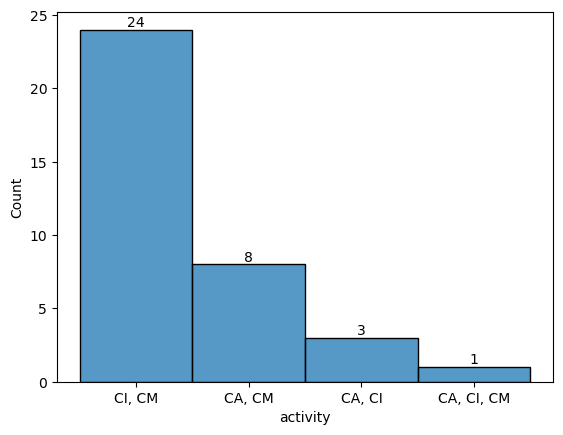

In [8]:
count = main_df['smiles'].value_counts()
print('duplicated smiles:', sum(count > 1))
smiles_grouped = main_df[main_df['smiles'].isin(count.index[count > 1])].groupby('smiles').agg({
    'activity': lambda x: ', '.join(sorted(x)),
    'HIV_active': 'sum'
  }).reset_index()
ax = sns.histplot(smiles_grouped['activity'])
ax.bar_label(ax.containers[0])
plt.show()

In [9]:
for _, row in smiles_grouped.iterrows():
  smiles, activity = row['smiles'], row['activity']
  rep_act, rep_active = ('CM', True) if activity == 'CA, CM' else ('CI', False)
  main_df.loc[main_df['smiles'] == smiles, 'activity'] = rep_act
  main_df.loc[main_df['smiles'] == smiles, 'HIV_active'] = rep_active

main_df = main_df.drop_duplicates()
main_df.describe()

,smiles,activity,HIV_active
count,41127,41127,41127
unique,41127,3,2
top,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,False
freq,1,39697,39697


### Data distribution

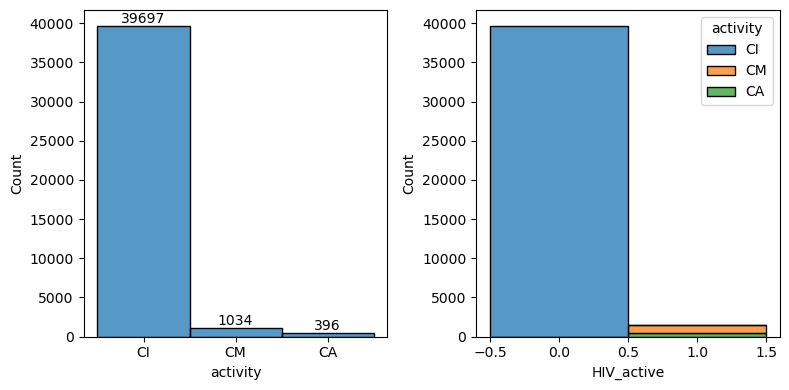

active:inactive ratio is 1:27.76


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

axx = sns.histplot(main_df['activity'], ax=ax1)
axx.bar_label(axx.containers[0])

sns.histplot(main_df, discrete=True, ax=ax2, x='HIV_active', hue='activity', multiple='stack')

fig.tight_layout()
plt.show()

print(f'active:inactive ratio is 1:{sum(~main_df['HIV_active'])/sum(main_df['HIV_active']):.2f}')

### Atom count distribution

[11:15:46] WARNING: not removing hydrogen atom without neighbors
[11:15:46] WARNING: not removing hydrogen atom without neighbors


All data 25.510321686483334 12.112791750089489


[11:15:50] WARNING: not removing hydrogen atom without neighbors
[11:15:50] WARNING: not removing hydrogen atom without neighbors


HIV inactive 25.19671511701136 11.583380292630888
HIV active 34.21608391608392 20.41405253707982


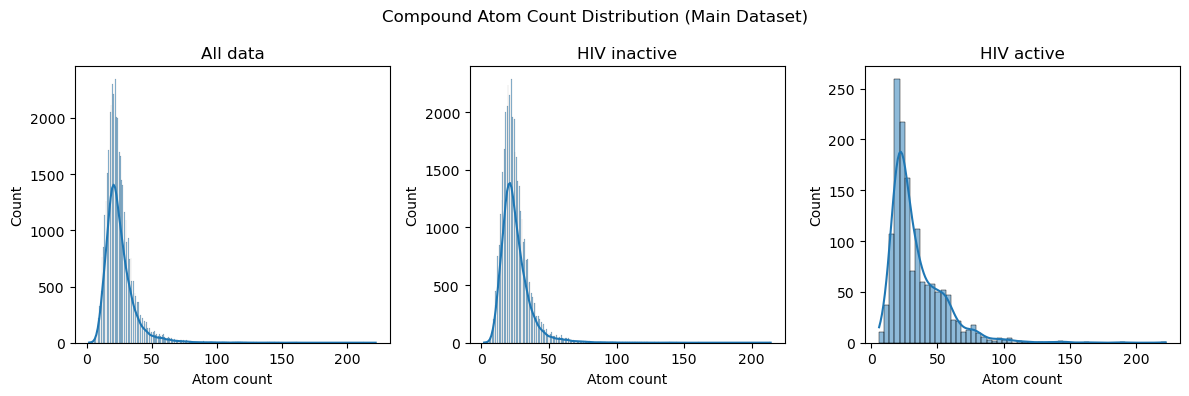

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
atom_count = [
  (main_df['smiles'], 'All data'),
  (main_df[~main_df['HIV_active']]['smiles'], 'HIV inactive'),
  (main_df[main_df['HIV_active']]['smiles'], 'HIV active')
]

for (ax, (df, title)) in zip(ax, atom_count):
  acount = df.apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
  plot = sns.histplot(acount, kde=True, ax=ax)
  plot.set_xlabel('Atom count')
  ax.title.set_text(title)
  print(title, acount.mean(), acount.std())

fig.suptitle('Compound Atom Count Distribution (Main Dataset)')
fig.tight_layout()

### Atom cloud

[11:15:55] WARNING: not removing hydrogen atom without neighbors
[11:15:55] WARNING: not removing hydrogen atom without neighbors


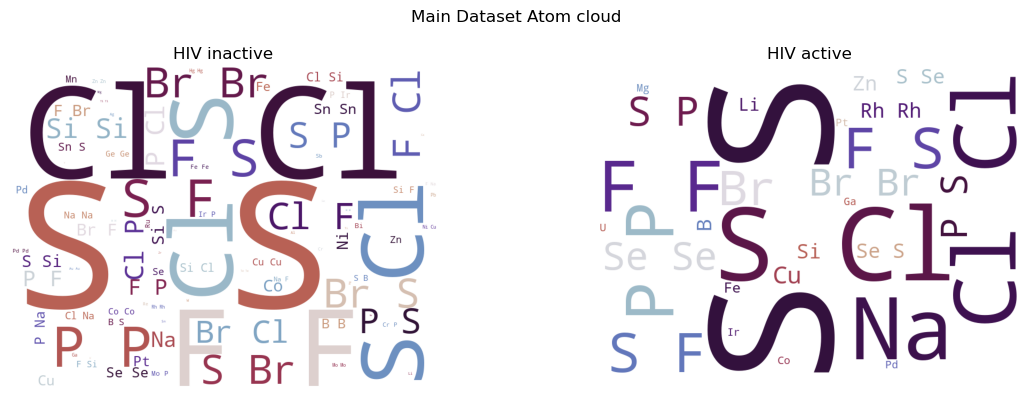

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
atom_sets = []

for (ax, (df, title)) in zip(ax, atom_count[1:]):
  atoms = []
  for mol in df.apply(lambda x: Chem.MolFromSmiles(x).GetAtoms()):
    atoms.extend([atom.GetSymbol() for atom in mol if atom.GetSymbol() not in ('C', 'N', 'O')])
  atom_sets.append(set(atoms))

  wc = WordCloud(background_color='white', colormap='twilight', width = 800, height = 600).generate(' '.join(atoms))
  ax.imshow(wc)
  ax.axis('off')
  ax.title.set_text(title)

fig.suptitle('Main Dataset Atom cloud')
fig.tight_layout()

common atom: 24
exclusive atom: 28
total atom: 52
{'Hg', 'Ru', 'Cs', 'Re', 'Mn', 'Ac', 'Bi', 'Cr', 'Ho', 'Sb', 'Mo', 'Ni', 'Sn', 'Al', 'Gd', 'Ca', 'H', 'Ge', 'Au', 'Zr', 'V', 'Ag', 'Te', 'Ti', 'W', 'Tb', 'Tl', 'Pb'}
{'Fe', 'Zn', 'S', 'Co', 'Li', 'Pd', 'P', 'Cu', 'Rh', 'Si', 'U', 'Na', 'K', 'B', 'Pt', 'Ir', 'Br', 'Cl', 'Se', 'As', 'F', 'I', 'Mg', 'Ga'}


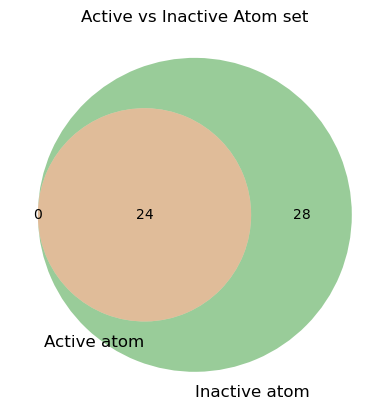

In [13]:
inactive_atom = atom_sets[0]
active_atom = atom_sets[1]

print('common atom:', len(set.intersection(active_atom, inactive_atom)))
print('exclusive atom:', len(set.symmetric_difference(active_atom, inactive_atom)))
print('total atom:', len(set.union(active_atom, inactive_atom)))
print(inactive_atom.difference(active_atom))
print(inactive_atom.intersection(active_atom))

venn2([active_atom, inactive_atom], ('Active atom', 'Inactive atom'))
plt.title('Active vs Inactive Atom set')
plt.show()

## Inspect reference dataset

### Remove duplicated values

In [15]:
ref_df.describe()

,activity,smiles,HIV_active
count,43850,43244,43850
unique,3,42671,2
top,CI,COC1=NC(=C(\N=C\C(OC(=O)C)C(OC(=O)C)C(COC(=O)C...,False
freq,42038,5,42038


In [16]:
print('drop', sum(ref_df.duplicated()), 'duplicated rows')
ref_df = ref_df.drop_duplicates()
ref_df.describe()

drop 1149 duplicated rows


,activity,smiles,HIV_active
count,42701,42698,42701
unique,3,42671,2
top,CI,[Na+].Oc1c(cc(c2cccnc12)S(=O)(=O)O)C(=O)Nc3ccc...,False
freq,41136,2,41136


duplicated smiles: 27


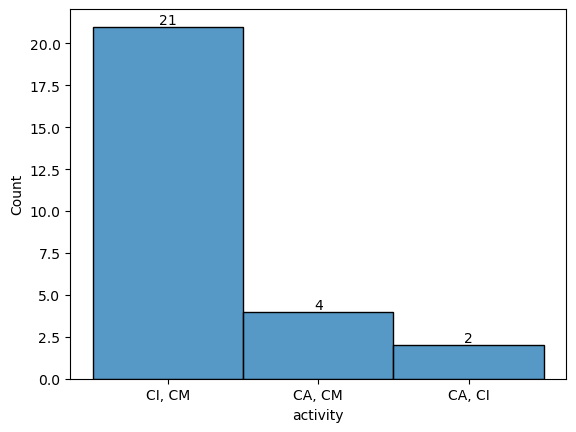

In [17]:
count = ref_df['smiles'].value_counts()
print('duplicated smiles:', sum(count > 1))
smiles_grouped = ref_df[ref_df['smiles'].isin(count.index[count > 1])].groupby('smiles').agg({
    'activity': lambda x: ', '.join(sorted(x)),
    'HIV_active': 'sum'
  }).reset_index()
ax = sns.histplot(smiles_grouped['activity'])
ax.bar_label(ax.containers[0])
plt.show()

In [18]:
for _, row in smiles_grouped.iterrows():
  smiles, activity = row['smiles'], row['activity']
  rep_act, rep_active = ('CM', True) if activity == 'CA, CM' else ('CI', False)
  ref_df.loc[ref_df['smiles'] == smiles, 'activity'] = rep_act
  ref_df.loc[ref_df['smiles'] == smiles, 'HIV_active'] = rep_active

ref_df = ref_df.drop_duplicates()
ref_df.describe()

,activity,smiles,HIV_active
count,42674,42671,42674
unique,3,42671,2
top,CI,CCC1=[O][Cu+2]2([O]=C(CC)CC(=[O]2)CC)[O]=C(CC)C1,False
freq,41136,1,41136


### Detect missing values

In [19]:
print('dropped missing values', ref_df.isna().apply(sum), sep='\n')
ref_df = ref_df.dropna()
ref_df.describe()

dropped missing values
activity      0
smiles        3
HIV_active    0
dtype: int64


,activity,smiles,HIV_active
count,42671,42671,42671
unique,3,42671,2
top,CI,CCC1=[O][Cu+2]2([O]=C(CC)CC(=[O]2)CC)[O]=C(CC)C1,False
freq,41135,1,41135


### Detect invalid compound

In [20]:
invalid_smiles = ref_df['smiles'].apply(Chem.MolFromSmiles).isna()
ref_df = ref_df[~invalid_smiles]
print('dropped', sum(invalid_smiles), 'invalid smiles')

[11:15:58] Explicit valence for atom # 5 Al, 9, is greater than permitted
[11:15:58] SMILES Parse Error: syntax error while parsing: [R]c1ccc2c(c1)C(CC3[C@@](C)(CCCC23C)C(=O)OC)OO
[11:15:58] SMILES Parse Error: Failed parsing SMILES '[R]c1ccc2c(c1)C(CC3[C@@](C)(CCCC23C)C(=O)OC)OO' for input: '[R]c1ccc2c(c1)C(CC3[C@@](C)(CCCC23C)C(=O)OC)OO'
[11:15:58] SMILES Parse Error: syntax error while parsing: O=C1O[Cu+2]2(Nc3ccccc3C(=O)O2)Nc4ccccc14.[RH].[RH]
[11:15:58] SMILES Parse Error: Failed parsing SMILES 'O=C1O[Cu+2]2(Nc3ccccc3C(=O)O2)Nc4ccccc14.[RH].[RH]' for input: 'O=C1O[Cu+2]2(Nc3ccccc3C(=O)O2)Nc4ccccc14.[RH].[RH]'
[11:15:58] SMILES Parse Error: syntax error while parsing: [R]Cc1cc(cc(C(=O)O)c1O)C(O)(c2cc(Cc3cc(cc(C(=O)O)c3O)\C(=C/4\C=CC(=O)C(=C4)C(=O)O)\c5ccc(O)c(c5)C(=O)O)c(O)c(c2)C(=O)O)c6cc(Cc7cc(C(c8ccc(O)c(c8)C(=O)O)c9cc(Cc%10cc(cc(C(=O)O)c%10O)C(O)(c%11ccc(O)c(c%11)C(=O)O)c%12cc([R])c(O)c(c%12)C(=O)O)cc(C(=O)O)c9O)c(O)c(c7)C(=O)O)cc(C(=O)O)c6O
[11:15:58] SMILES Parse Error: Faile

[11:15:59] SMILES Parse Error: syntax error while parsing: [R]C.[R]C.[R]\C=C\C.CN1C(CO)C(=C(C(=O)CC\C=C\C2CC3CC3C2)C1=O)O
[11:15:59] SMILES Parse Error: Failed parsing SMILES '[R]C.[R]C.[R]\C=C\C.CN1C(CO)C(=C(C(=O)CC\C=C\C2CC3CC3C2)C1=O)O' for input: '[R]C.[R]C.[R]\C=C\C.CN1C(CO)C(=C(C(=O)CC\C=C\C2CC3CC3C2)C1=O)O'
[11:15:59] SMILES Parse Error: syntax error while parsing: [R]N.COC1=CC(=O)c2nc(ccc2C1=O)c3cc(c(C)c(n3)C(=O)O)c4ccc(OC)c(OC)c4O
[11:15:59] SMILES Parse Error: Failed parsing SMILES '[R]N.COC1=CC(=O)c2nc(ccc2C1=O)c3cc(c(C)c(n3)C(=O)O)c4ccc(OC)c(OC)c4O' for input: '[R]N.COC1=CC(=O)c2nc(ccc2C1=O)c3cc(c(C)c(n3)C(=O)O)c4ccc(OC)c(OC)c4O'
[11:15:59] SMILES Parse Error: syntax error while parsing: [R]C1=C(Oc2c(O)cc(O)cc2C1=O)c3ccc(O)c(O)c3
[11:15:59] SMILES Parse Error: Failed parsing SMILES '[R]C1=C(Oc2c(O)cc(O)cc2C1=O)c3ccc(O)c(O)c3' for input: '[R]C1=C(Oc2c(O)cc(O)cc2C1=O)c3ccc(O)c(O)c3'
[11:15:59] Explicit valence for atom # 22 B, 4, is greater than permitted
[11:15:59] SMILES Pa

dropped 919 invalid smiles


### Data distribution

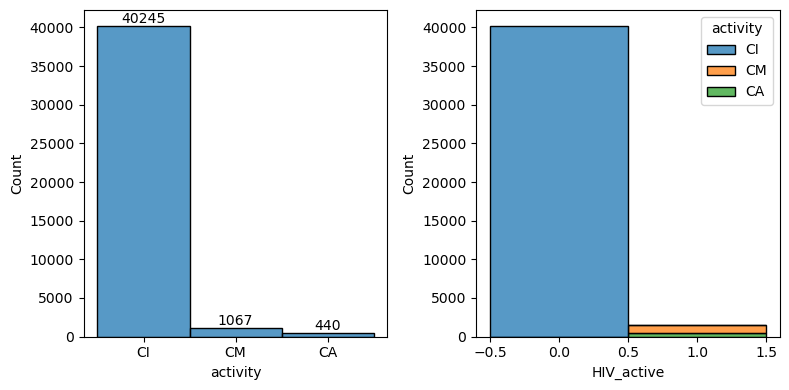

active:inactive ratio is 1:26.71


In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

axx = sns.histplot(ref_df['activity'], ax=ax1)
axx.bar_label(axx.containers[0])

sns.histplot(ref_df, discrete=True, ax=ax2, x='HIV_active', hue='activity', multiple='stack')

fig.tight_layout()
plt.show()

print(f'active:inactive ratio is 1:{sum(~ref_df['HIV_active'])/sum(ref_df['HIV_active']):.2f}')

[11:16:03] WARNING: not removing hydrogen atom without neighbors


All data 25.393274573673118 12.05909303326921


[11:16:07] WARNING: not removing hydrogen atom without neighbors


HIV inactive 25.071586532488507 11.532052753593195
HIV active 33.984074319840744 20.02885729866674


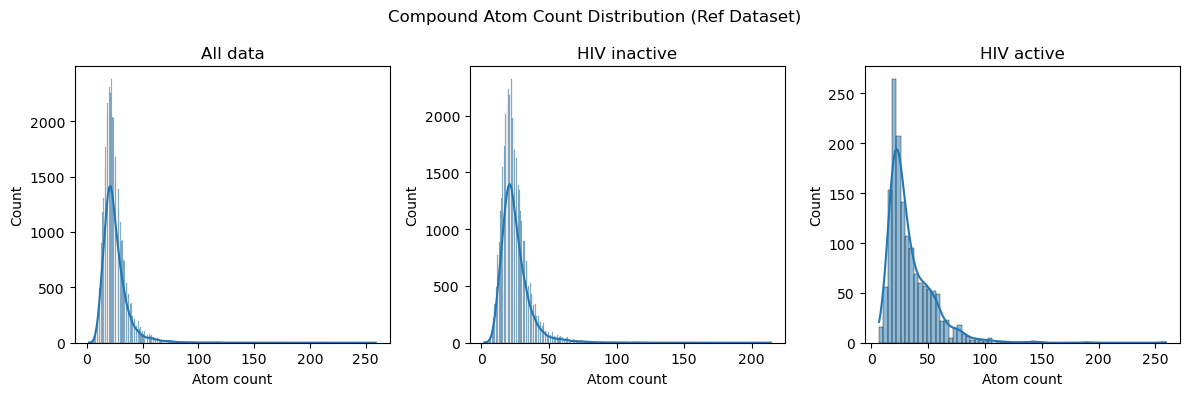

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
atom_count = [
  (ref_df['smiles'], 'All data'),
  (ref_df[~ref_df['HIV_active']]['smiles'], 'HIV inactive'),
  (ref_df[ref_df['HIV_active']]['smiles'], 'HIV active')
]

for (ax, (df, title)) in zip(ax, atom_count):
  acount = df.apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
  plot = sns.histplot(acount, kde=True, ax=ax)
  plot.set_xlabel('Atom count')
  ax.title.set_text(title)
  print(title, acount.mean(), acount.std())

fig.suptitle('Compound Atom Count Distribution (Ref Dataset)')
fig.tight_layout()

[11:16:12] WARNING: not removing hydrogen atom without neighbors


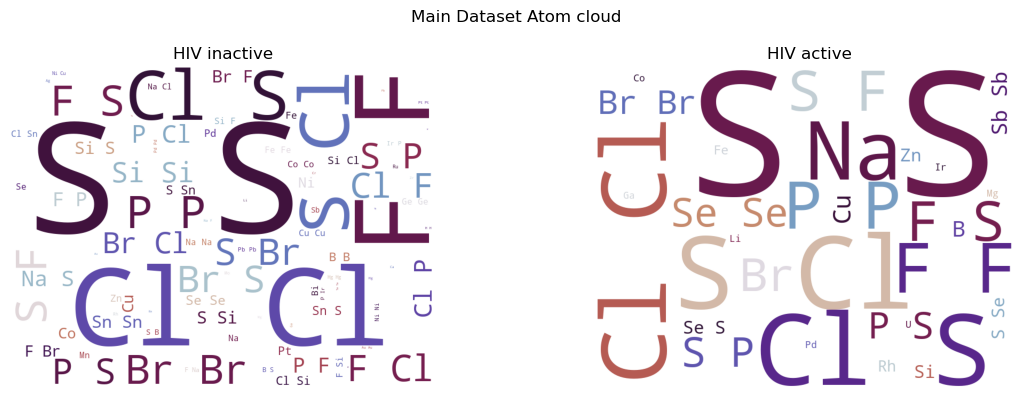

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
atom_sets = []

for (ax, (df, title)) in zip(ax, atom_count[1:]):
  atoms = []
  for mol in df.apply(lambda x: Chem.MolFromSmiles(x).GetAtoms()):
    atoms.extend([atom.GetSymbol() for atom in mol if atom.GetSymbol() not in ('C', 'N', 'O')])
  atom_sets.append(set(atoms))

  wc = WordCloud(background_color='white', colormap='twilight', width = 800, height = 600).generate(' '.join(atoms))
  ax.imshow(wc)
  ax.axis('off')
  ax.title.set_text(title)

fig.suptitle('Main Dataset Atom cloud')
fig.tight_layout()

common atom: 23
exclusive atom: 28
total atom: 51
{'Hg', 'Ru', 'Cs', 'Re', 'Mn', 'Ac', 'Bi', 'Cr', 'Ho', 'Mo', 'Ni', 'Sn', 'Cd', 'Ca', 'Pt', 'H', 'Ge', 'As', 'Au', 'Zr', 'V', 'Ba', 'Ag', 'Te', 'Ti', 'W', 'Tb', 'Pb'}
{'Fe', 'Zn', 'S', 'Co', 'Sb', 'Li', 'Pd', 'P', 'Cu', 'Rh', 'Si', 'U', 'Na', 'K', 'B', 'Ir', 'Br', 'Cl', 'Se', 'F', 'I', 'Mg', 'Ga'}


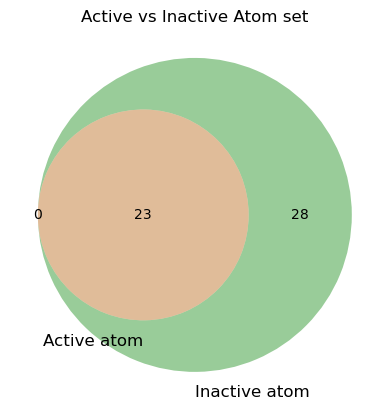

In [24]:
inactive_atom = atom_sets[0]
active_atom = atom_sets[1]

print('common atom:', len(set.intersection(active_atom, inactive_atom)))
print('exclusive atom:', len(set.symmetric_difference(active_atom, inactive_atom)))
print('total atom:', len(set.union(active_atom, inactive_atom)))
print(inactive_atom.difference(active_atom))
print(inactive_atom.intersection(active_atom))

venn2([active_atom, inactive_atom], ('Active atom', 'Inactive atom'))
plt.title('Active vs Inactive Atom set')
plt.show()

## Main Dataset vs Reference Dataset

common compound: 4053
exclusive compound: 74773
total compound: 78826


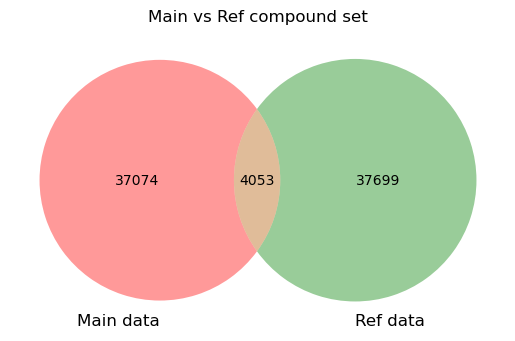

In [25]:
main_set = set(main_df['smiles'])
ref_set = set(ref_df['smiles'])

print('common compound:', len(set.intersection(main_set, ref_set)))
print('exclusive compound:', len(set.symmetric_difference(main_set, ref_set)))
print('total compound:', len(set.union(main_set, ref_set)))

venn2([main_set, ref_set], ('Main data', 'Ref data'))
plt.title('Main vs Ref compound set')
plt.show()

20
C C C C C C C C N C C S C C C C C C N O 

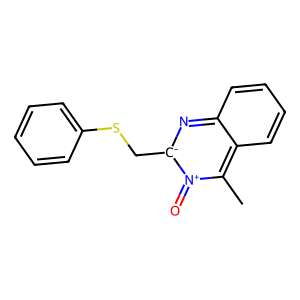

In [31]:
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles('Cc1c2ccccc2n[c-](CSc2ccccc2)[n+]1=O')
print(mol.GetNumAtoms())
print(mol.GetAtoms())
for atom in mol.GetAtoms():
  print(atom.GetSymbol(), end=' ')
  
Draw.MolToImage(mol)

In [27]:
Chem.RDKFingerprint(Chem.MolFromSmiles('CO'))